## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from equiv_layer import EqLayer
from carto_map_plot import point_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING BDG FILE
header=['LONG', 'LAT', 'ALT_GEOM', 'GRAV']
path = '../data/BDG/'
uf = 'CE'
name_bdg = '_file.txt'
bdg = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_bdg), sep='\s+',names=header, skiprows=1)
# bdg

In [4]:
# IMPORTING EIGEN FILE
name_eigen = '.dat'
eigen = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen), sep='\s+',skiprows=32, \
                    usecols=(4,), names=['GRAV'])
# eigen

In [5]:
# Obtaining short wavelength signals
disturb = bdg.GRAV.values - eigen.GRAV.values

data = {'LONG':bdg.LONG.values, \
        'LAT':bdg.LAT.values, \
        'ALT':bdg.ALT_GEOM.values, \
        'BDG':bdg.GRAV.values, \
        'EIGEN':eigen.GRAV.values, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST
0,-37.49170,-4.810600,45.800,978052.07,978051.463230,0.606770
1,-39.93720,-6.667800,336.260,977993.08,977995.771511,-2.691511
2,-39.95500,-6.736400,348.730,977994.36,977991.532307,2.827693
3,-39.80110,-6.564400,295.330,978004.34,978004.115348,0.224652
4,-40.60030,-6.287800,483.860,977948.73,977955.028453,-6.298453
...,...,...,...,...,...,...
972,-38.47461,-3.726217,48.419,978060.48,978060.467707,0.012293
973,-38.57729,-3.747680,16.512,978069.08,978064.360905,4.719095
974,-40.68704,-5.201768,286.067,977971.80,977975.906004,-4.106004
975,-39.29450,-3.372917,38.903,978055.77,978062.163206,-6.393206


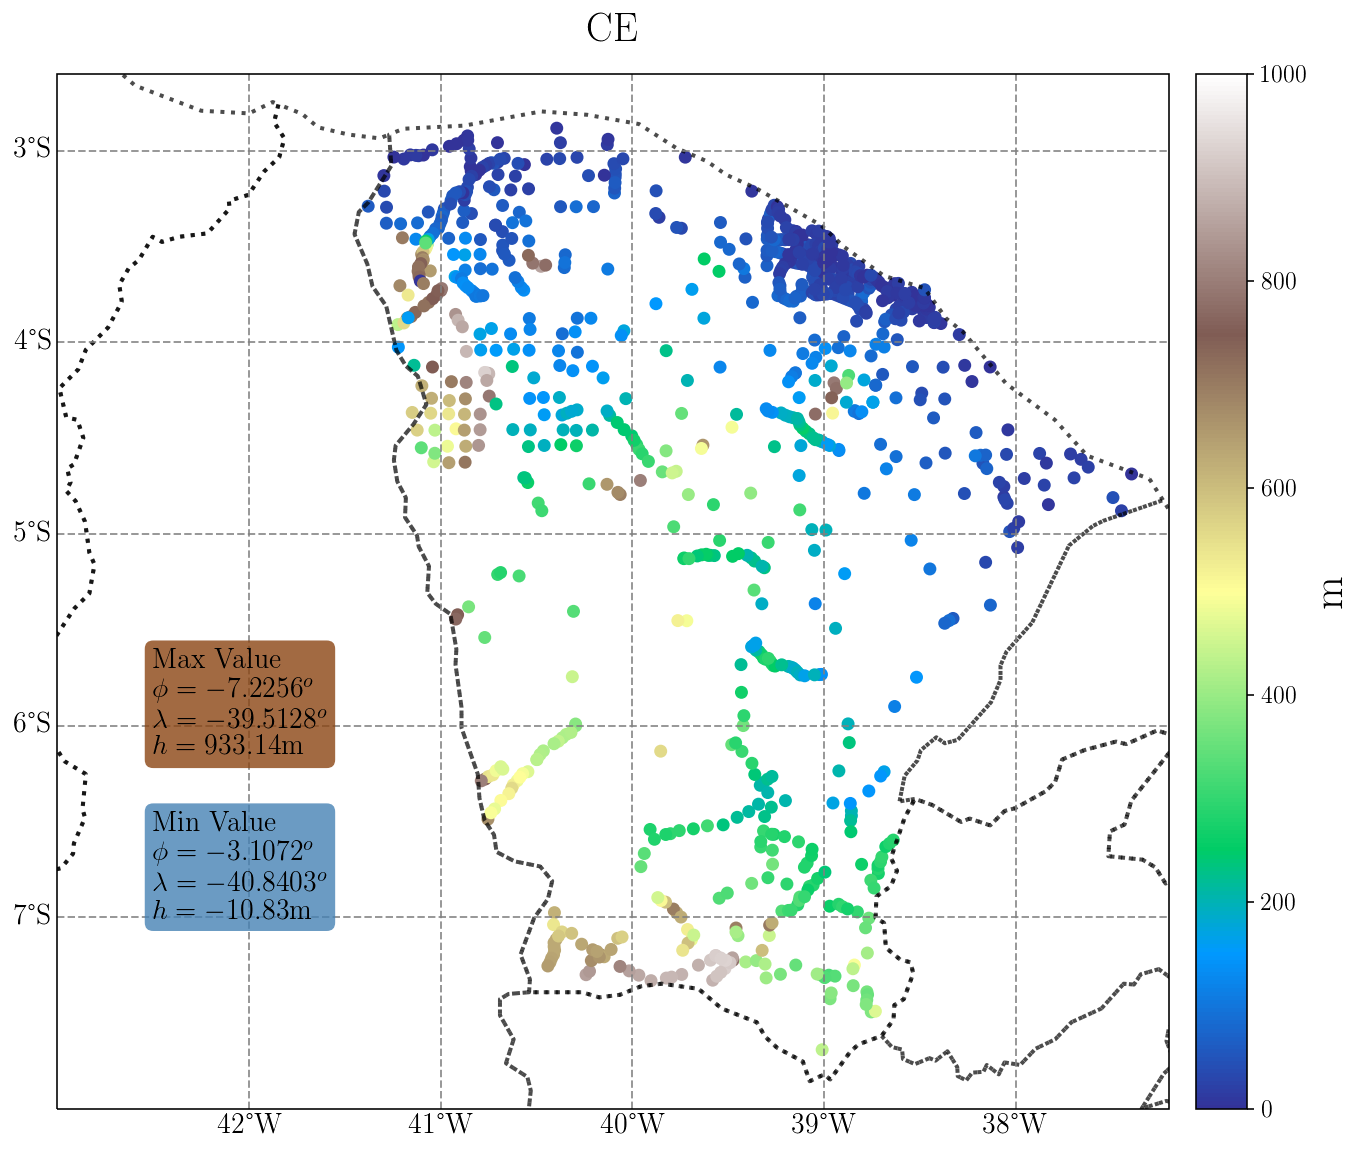

In [6]:
point_map(df.LONG, df.LAT, df.ALT, df.ALT, uf, fig_size=(12.,14.), region=[-43,-37.2,-8,-2.6], \
          sign=(-42.5,-42.5,-6.15,-7), shrink=0.68, cmap='terrain', lim_val=(True,True,0.,1000.))

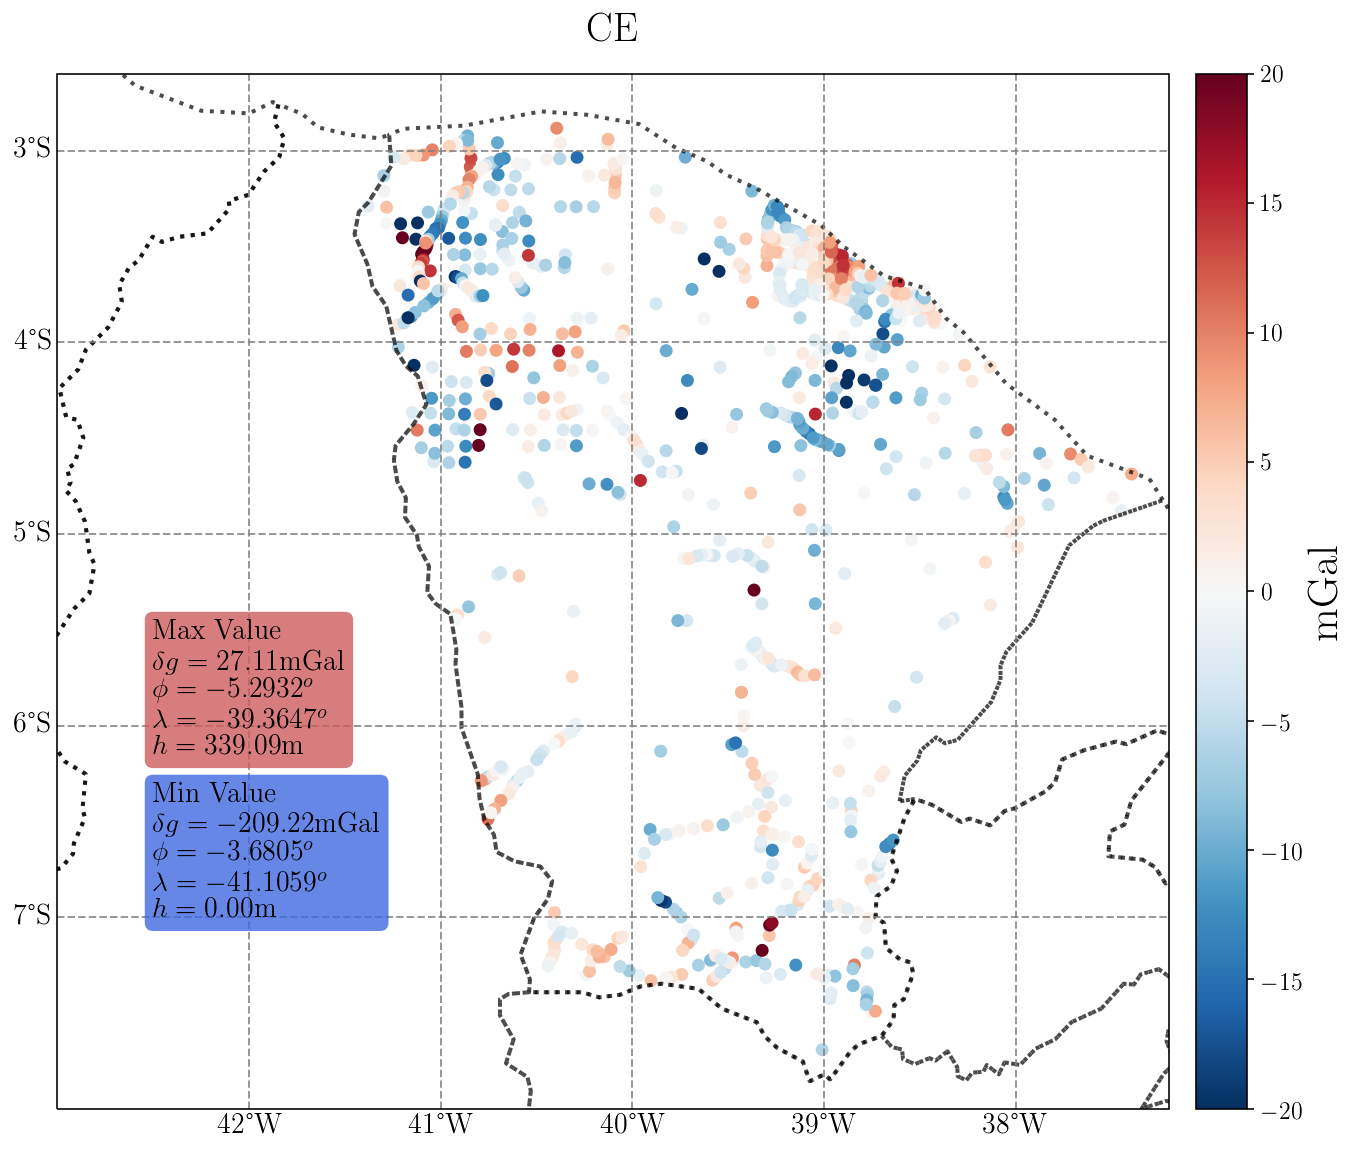

In [7]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-43,-37.2,-8,-2.6], \
          sign=(-42.5,-42.5,-6.15,-7), shrink=0.68, lim_val=(True, 20.))

In [8]:
index = np.argmax(df.ALT.values)
print('MAX', index, df.ALT[index], df.DIST[index])

index = np.argmin(df.ALT.values)
print('MIN', index, df.ALT[index], df.DIST[index])

MAX 572 933.14 -1.4403166001429781
MIN 517 -10.83 8.079011099995114


In [9]:
index_max = np.argmax(df.DIST.values)
print('MAX', index_max, df.ALT[index_max], df.DIST[index_max])

index_min = np.argmin(df.DIST.values)
print('MIN', index_min, df.ALT[index_min], df.DIST[index_min])

MAX 727 339.09 27.106311499956064
MIN 849 0.0 -209.21810870000627


In [10]:
disturb = np.delete(df.DIST.values, index_min)
longitude = np.delete(df.LONG.values, index_min)
latitude = np.delete(df.LAT.values, index_min)
altitude = np.delete(df.ALT.values, index_min)

In [11]:
index_max = np.argmax(disturb)
print('MAX', index_max, df.ALT[index_max], df.DIST[index_max])

index_min = np.argmin(disturb)
print('MIN', index_min, df.ALT[index_min], df.DIST[index_min])

MAX 727 339.09 27.106311499956064
MIN 811 159.05 -60.477710800012574


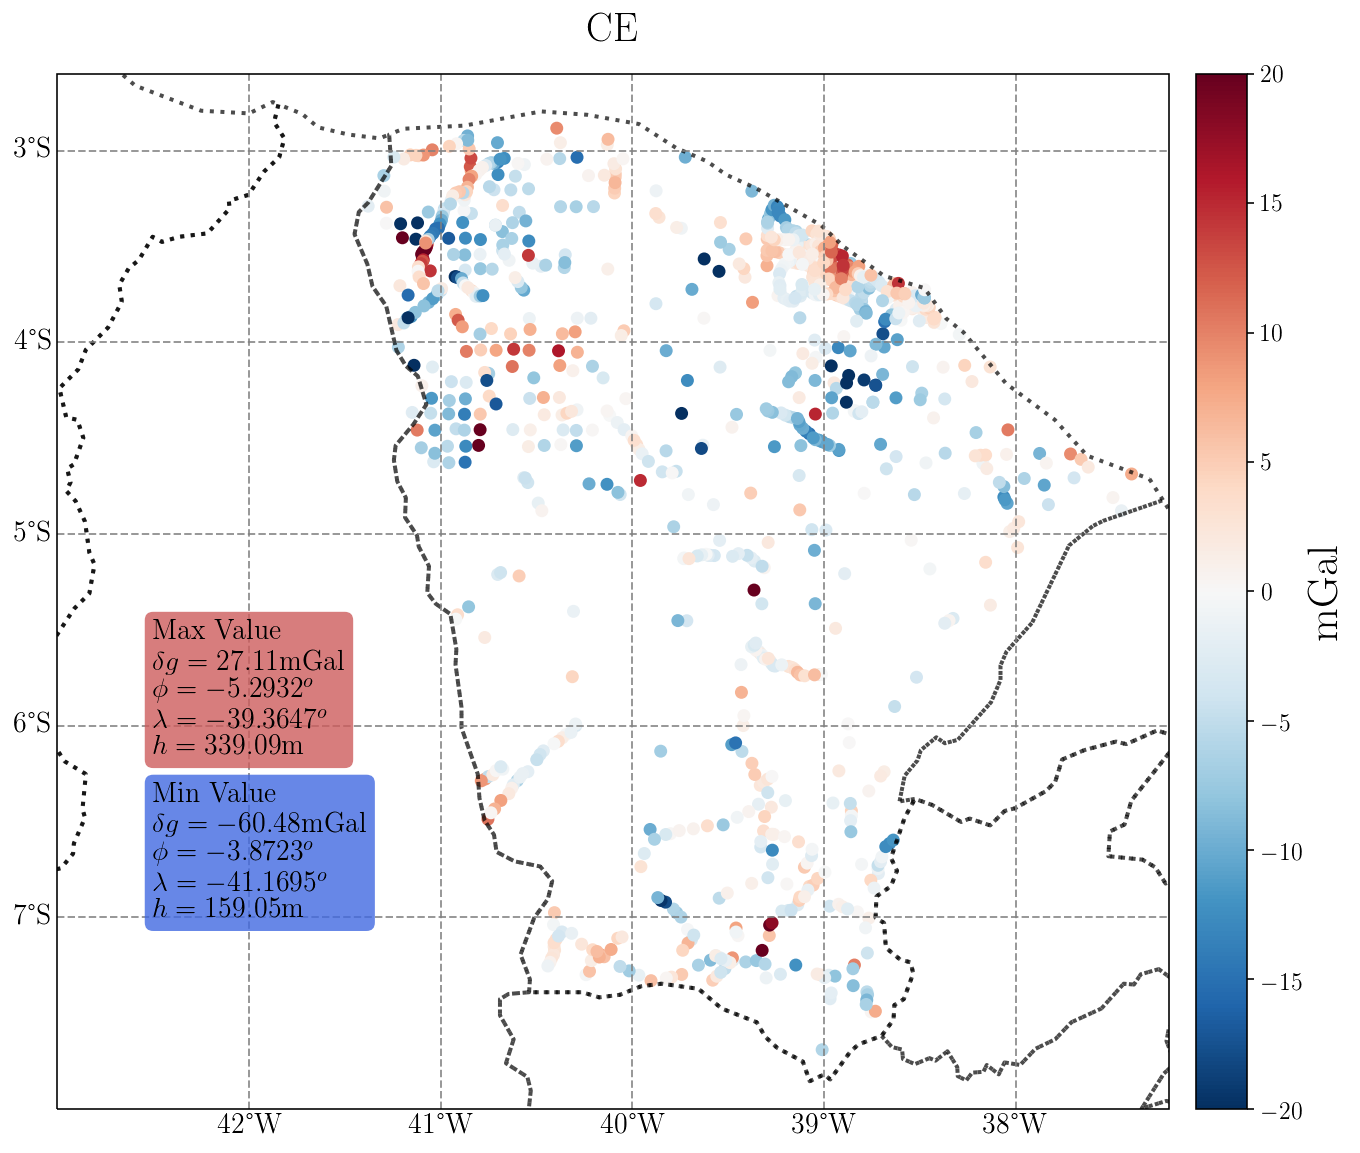

In [12]:
point_map(longitude, latitude, altitude, disturb, uf, fig_size=(12.,14.), region=[-43,-37.2,-8,-2.6], \
          sign=(-42.5,-42.5,-6.15,-7), shrink=0.68, lim_val=(True, 20.))

### Calculating rotation matrices and Cartesian coordinates

In [13]:
# # Calculating Cartesian coordinates
# x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
# R = np.array(rotation_matrix(df.LONG, df.LAT))

In [14]:
# Calculating Cartesian coordinates
x, y, z = geodetic2cartesian(longitude, latitude, altitude)
R = np.array(rotation_matrix(longitude, latitude))

## Estimating the first set of point-mass parameters

In [15]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [16]:
indl = np.arange(disturb.size)
mi_c = 1e-15
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

3000.0 <class 'numpy.ndarray'>


In [17]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

# latcl = df.LAT[indl]
# loncl = df.LONG[indl]
latcl = latitude[indl]
loncl = longitude[indl]

In [18]:
Rcl = R[:, indl]

In [19]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
# Lay = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
Lay = EqLayer(longitude, latitude, np.zeros_like(longitude)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

(976, 976)


In [20]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [21]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

976


In [22]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [23]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

1.139936839533413

In [24]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [25]:
rabs_max.append(rabs_max_l)

In [26]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

1.139936839533413


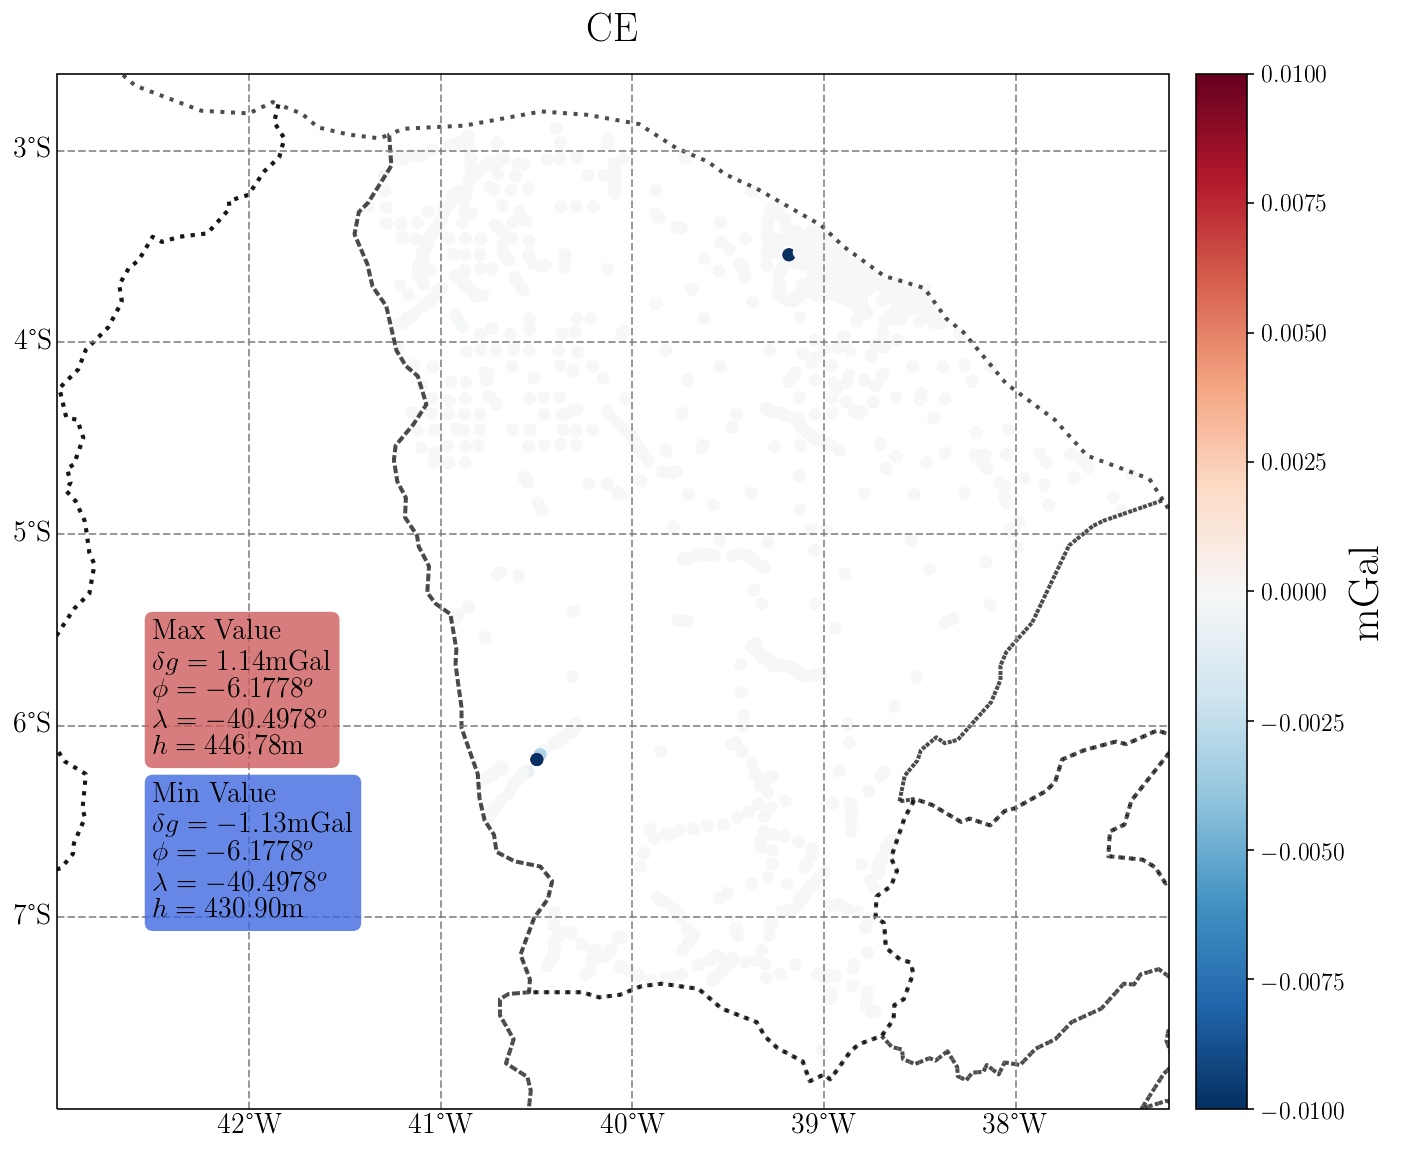

In [27]:
point_map(longitude, latitude, altitude, rc, uf, fig_size=(12.,14.), region=[-43,-37.2,-8,-2.6], \
          sign=(-42.5,-42.5,-6.15,-7), shrink=0.68, lim_val=(True, 1e-2))

In [28]:
index_max = np.argmax(rc)
print('MAX', index_max, df.ALT[index_max], rc[index_max])

index_min = np.argmin(rc)
print('MIN', index_min, df.ALT[index_min], rc[index_min])
res = np.delete(rc, [index_min, index_max])
lon = np.delete(longitude, [index_min, index_max])
lat = np.delete(latitude, [index_min, index_max])
alt = np.delete(altitude, [index_min, index_max])

MAX 316 446.78 1.139936839533413
MIN 317 430.9 -1.1283270783531467


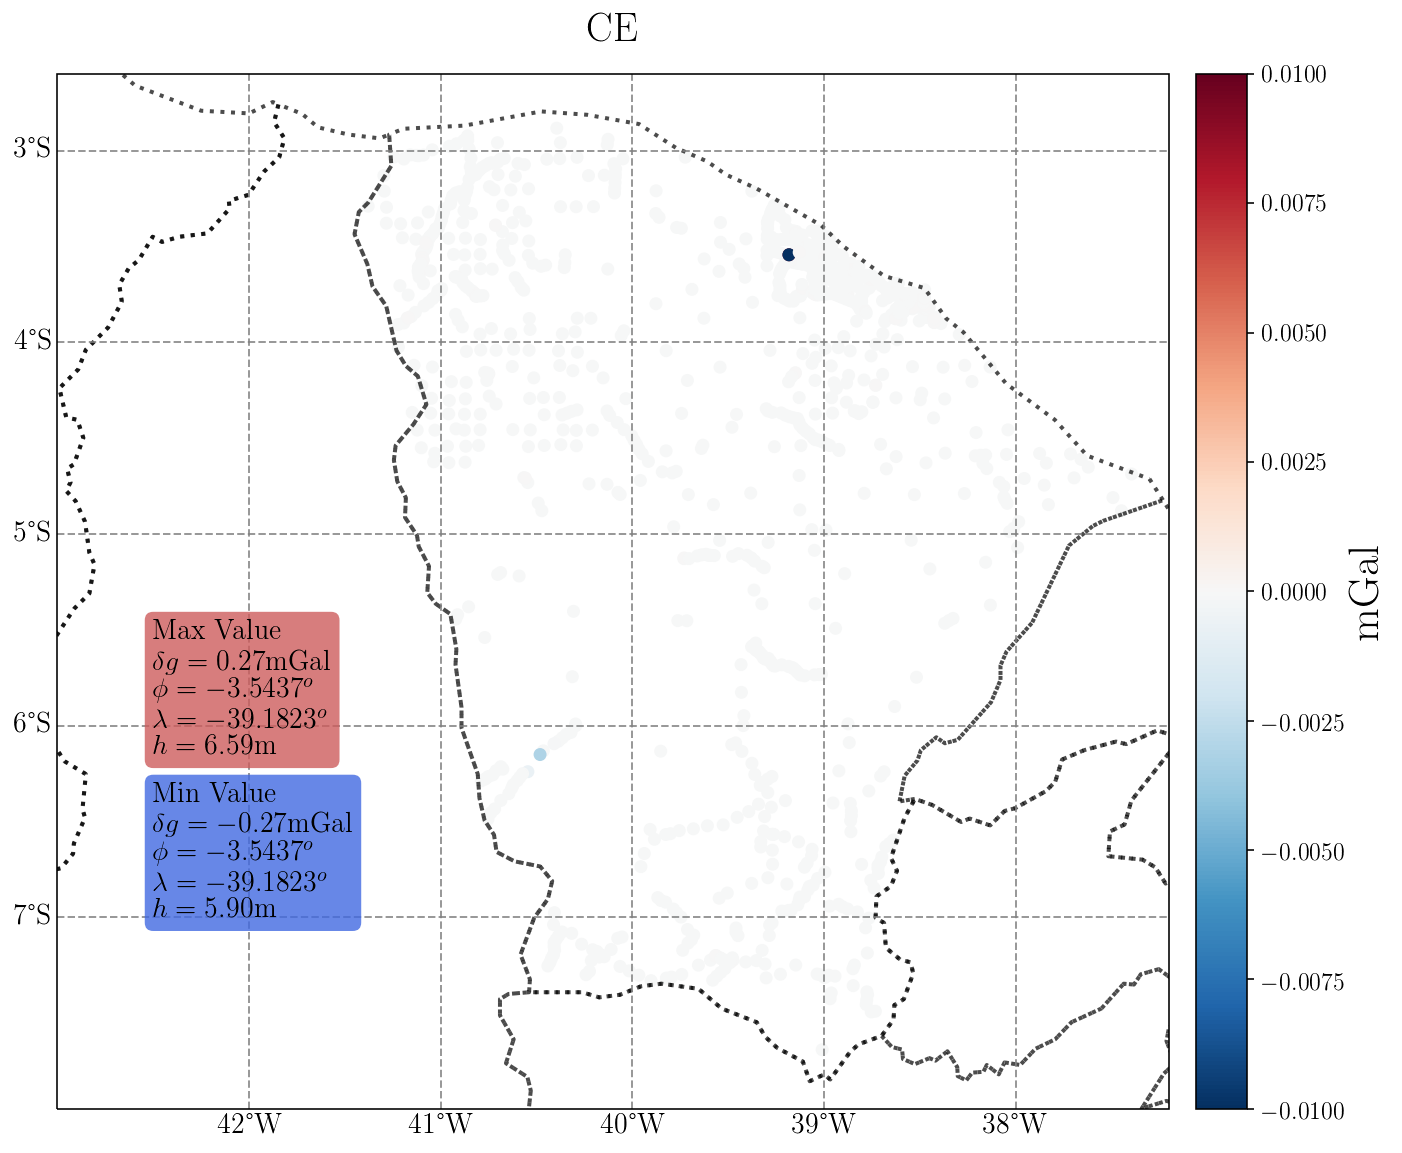

In [29]:
point_map(lon, lat, alt, res, uf, fig_size=(12.,14.), region=[-43,-37.2,-8,-2.6], \
          sign=(-42.5,-42.5,-6.15,-7), shrink=0.68, lim_val=(True, 1e-2))

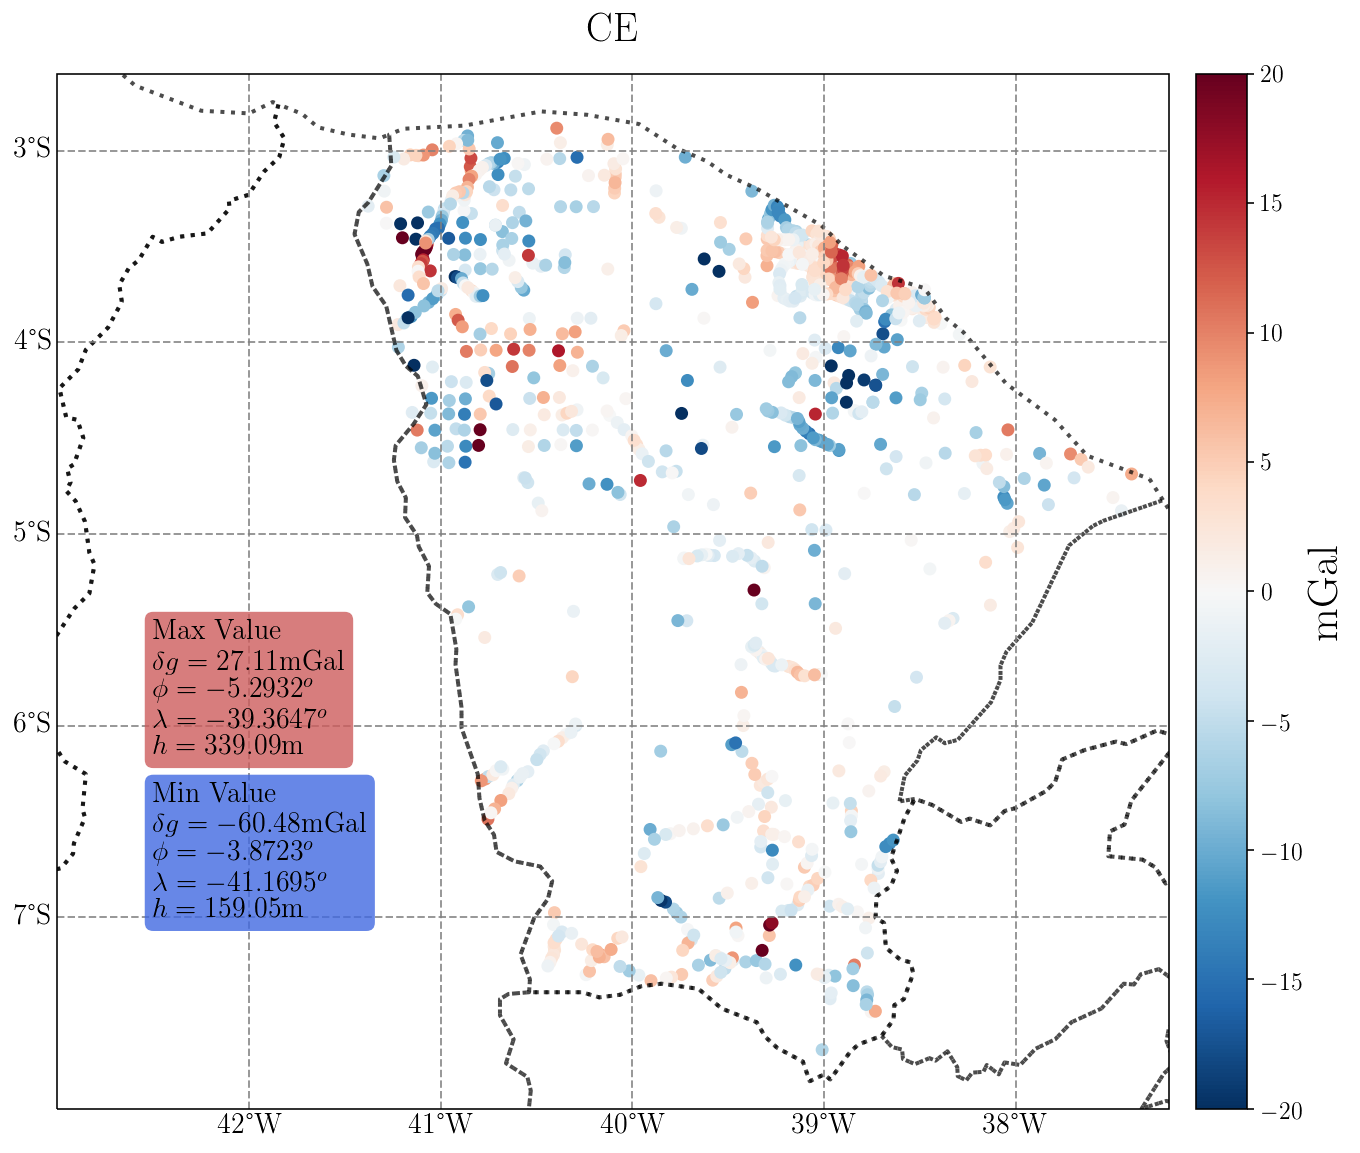

In [31]:
point_map(longitude, latitude, altitude, disturb, uf, fig_size=(12.,14.), region=[-43,-37.2,-8,-2.6], \
          sign=(-42.5,-42.5,-6.15,-7), shrink=0.68, lim_val=(True, 20.))

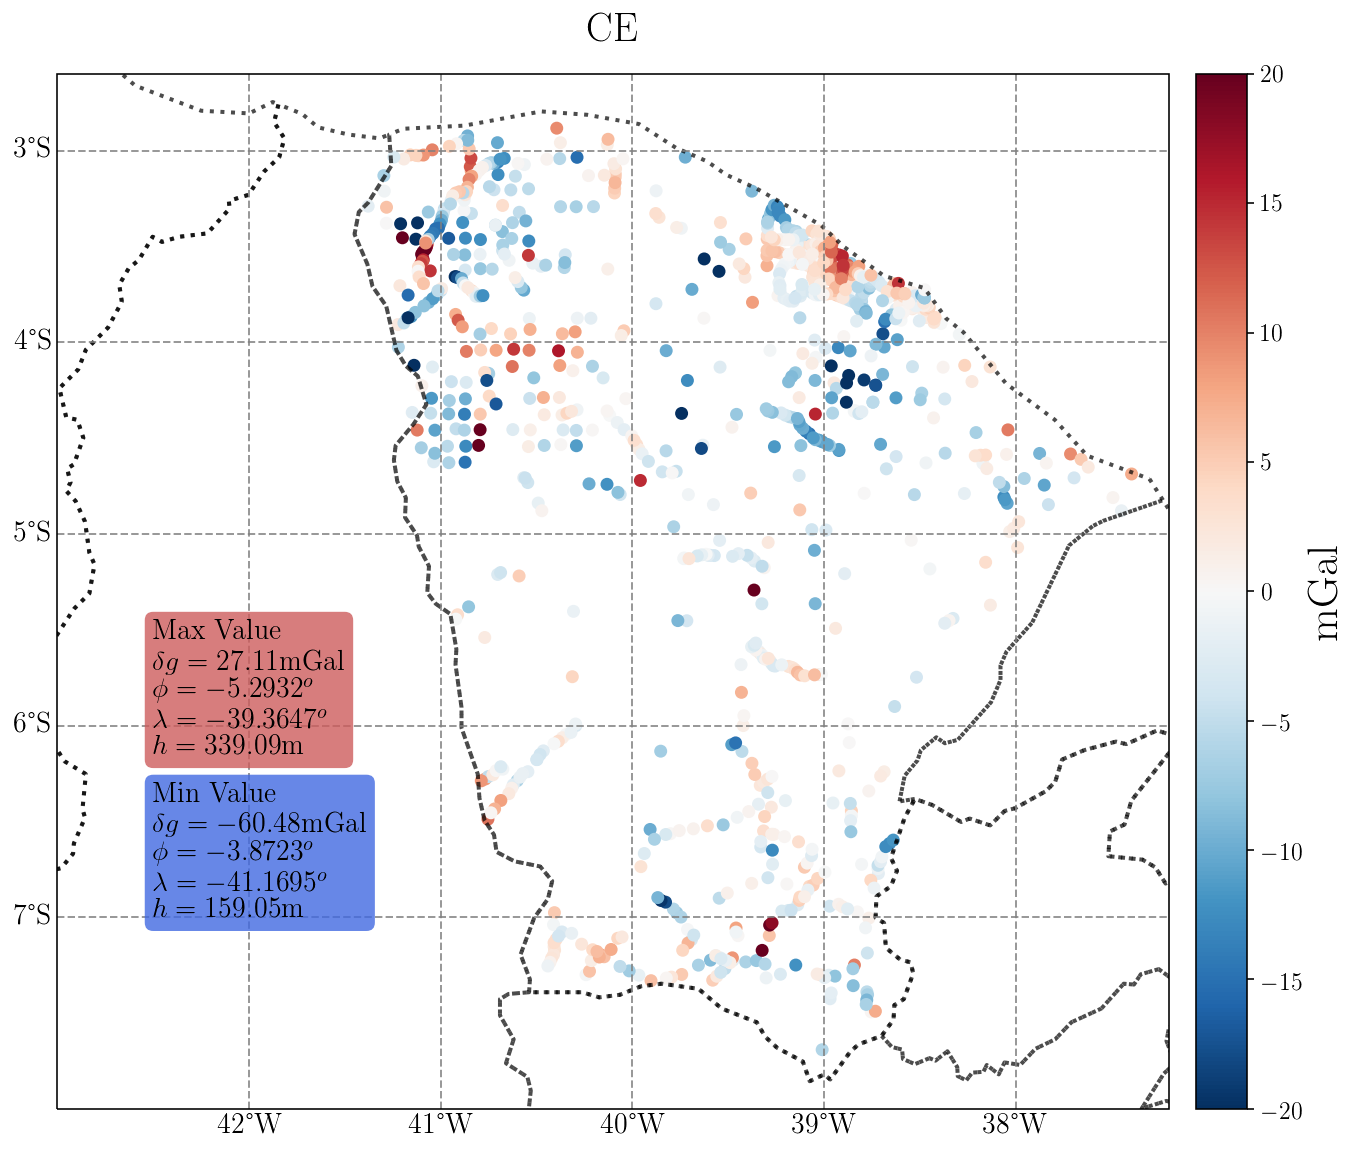

In [32]:
point_map(longitude, latitude, altitude, np.dot(Acc_l, p_L2), uf, fig_size=(12.,14.), region=[-43,-37.2,-8,-2.6], \
          sign=(-42.5,-42.5,-6.15,-7), shrink=0.68, lim_val=(True, 20.))

In [33]:
# print(len([value for value in rc if value > 1e-5]))
# print([value for value in rc if value > 1e-5])

In [34]:
bdg_data = np.delete(df.BDG.values, index_min)
eigen_data = np.delete(df.EIGEN.values, index_min)
new_data = {'LONG':longitude, \
            'LAT':latitude, \
            'ALT':altitude, \
            'BDG':bdg_data, \
            'EIGEN':eigen_data, \
            'DIST':disturb, \
            'RHO':p_L2, \
            'RESID':rc}
df = pd.DataFrame(new_data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST,RHO,RESID
0,-37.49170,-4.810600,45.800,978052.07,978051.463230,0.606770,2.073933e+11,-2.175189e-08
1,-39.93720,-6.667800,336.260,977993.08,977995.771511,-2.691511,-1.018981e+12,-8.494518e-07
2,-39.95500,-6.736400,348.730,977994.36,977991.532307,2.827693,1.257057e+12,-7.667979e-07
3,-39.80110,-6.564400,295.330,978004.34,978004.115348,0.224652,7.916562e+11,-3.944560e-07
4,-40.60030,-6.287800,483.860,977948.73,977955.028453,-6.298453,-3.302531e+12,-3.203505e-05
...,...,...,...,...,...,...,...,...
971,-38.47461,-3.726217,48.419,978060.48,978060.467707,0.012293,1.068578e+12,-1.925620e-08
972,-38.57729,-3.747680,16.512,978069.08,978064.360905,4.719095,-2.724624e+13,-1.520175e-08
973,-40.68704,-5.201768,286.067,977971.80,977975.906004,-4.106004,-1.493684e+12,-2.289602e-07
974,-39.29450,-3.372917,38.903,978055.77,978062.163206,-6.393206,1.214511e+12,-2.632412e-09


In [35]:
print(df.RESID.min(), df.RESID.max())

-1.1283270783531467 1.139936839533413


### Upward Continuation

In [36]:
# up_cont = Lay.continuation(df.LONG,df.LAT,6000.,df.LONG,df.LAT,-3000.,p_L2)

In [37]:
Layer = EqLayer(longitude, latitude, np.zeros_like(longitude)-hcl)
up_cont = Layer.continuation(longitude,latitude,3000.,-3000.,p_L2)

The transformation is an upward continuation


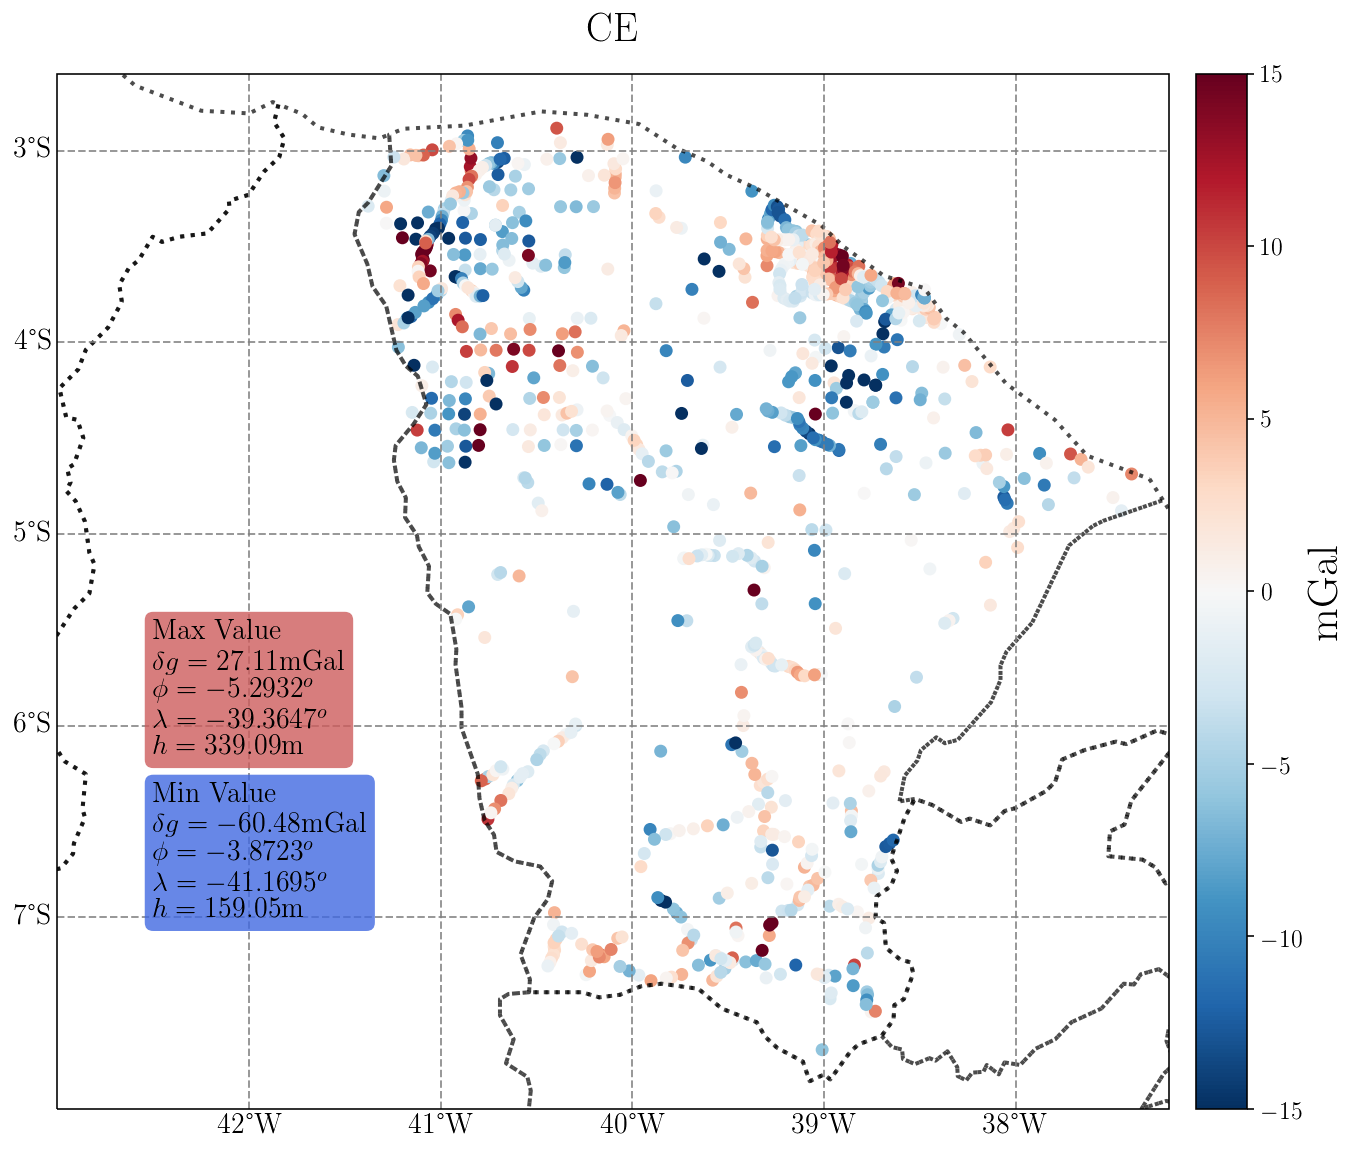

In [38]:
point_map(longitude, latitude, altitude, disturb, uf, fig_size=(12.,14.), region=[-43,-37.2,-8,-2.6], \
          sign=(-42.5,-42.5,-6.15,-7), shrink=0.68, lim_val=(True, 15.))

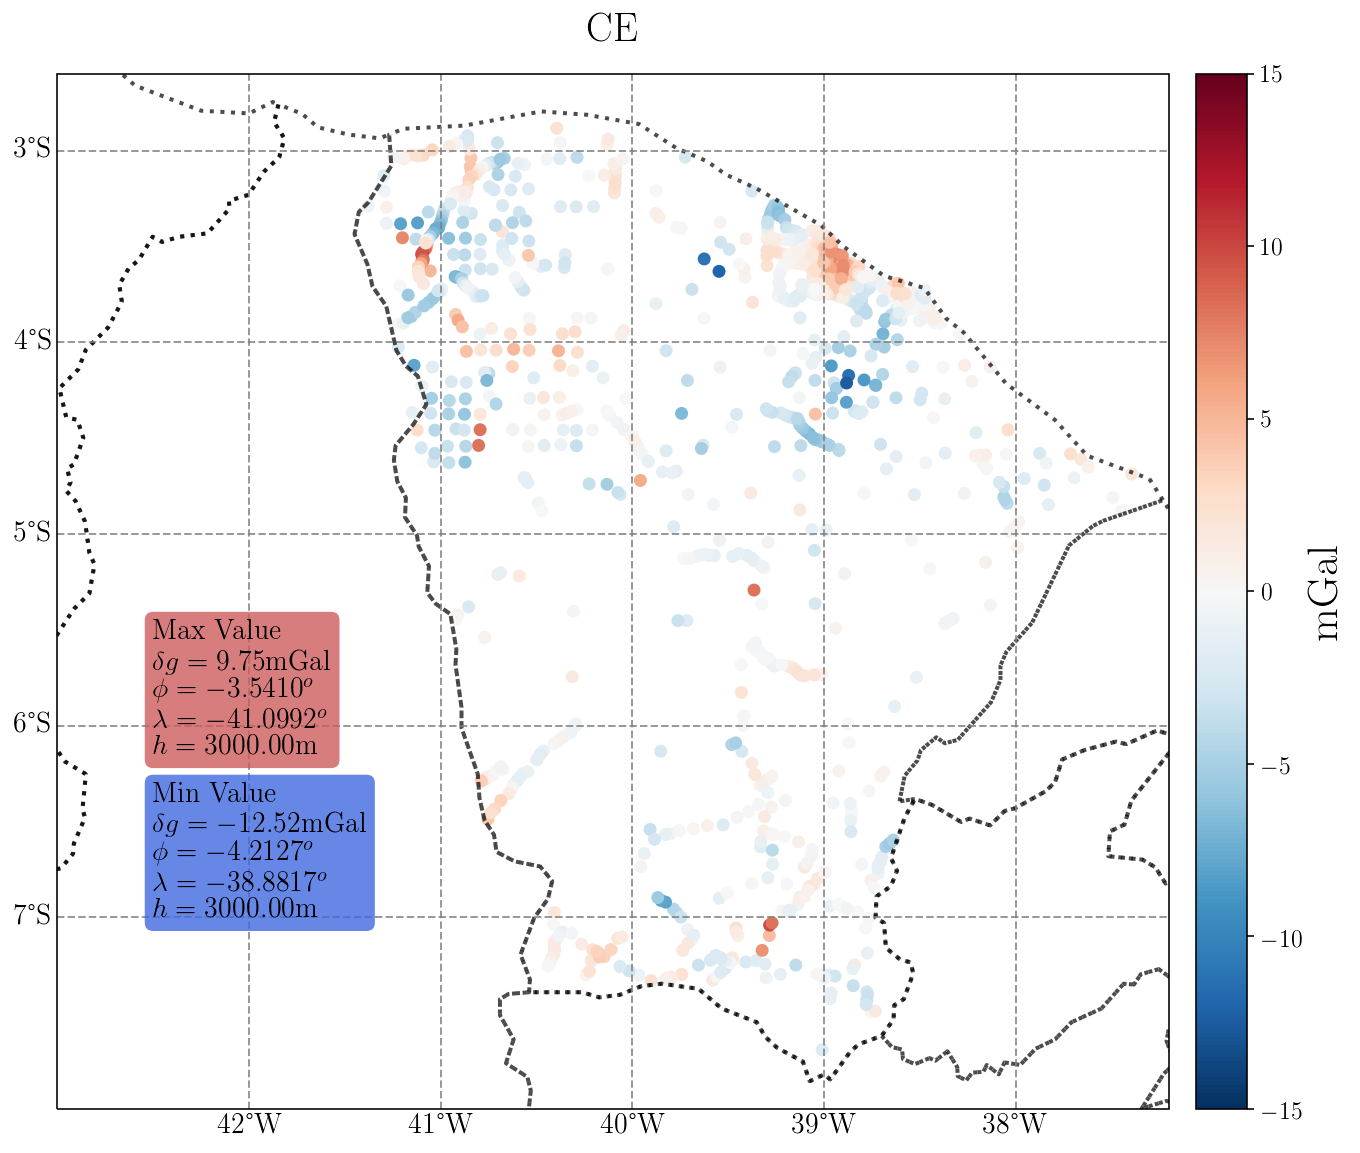

In [39]:
point_map(longitude, latitude, np.zeros_like(df.LONG)+3000., up_cont, uf, fig_size=(12.,14.), \
          region=[-43,-37.2,-8,-2.6], sign=(-42.5,-42.5,-6.15,-7), shrink=0.68, lim_val=(True, 15.))

In [40]:
# Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(longitude, latitude,6000.,-3000.,p_L2)

The transformation is an upward continuation


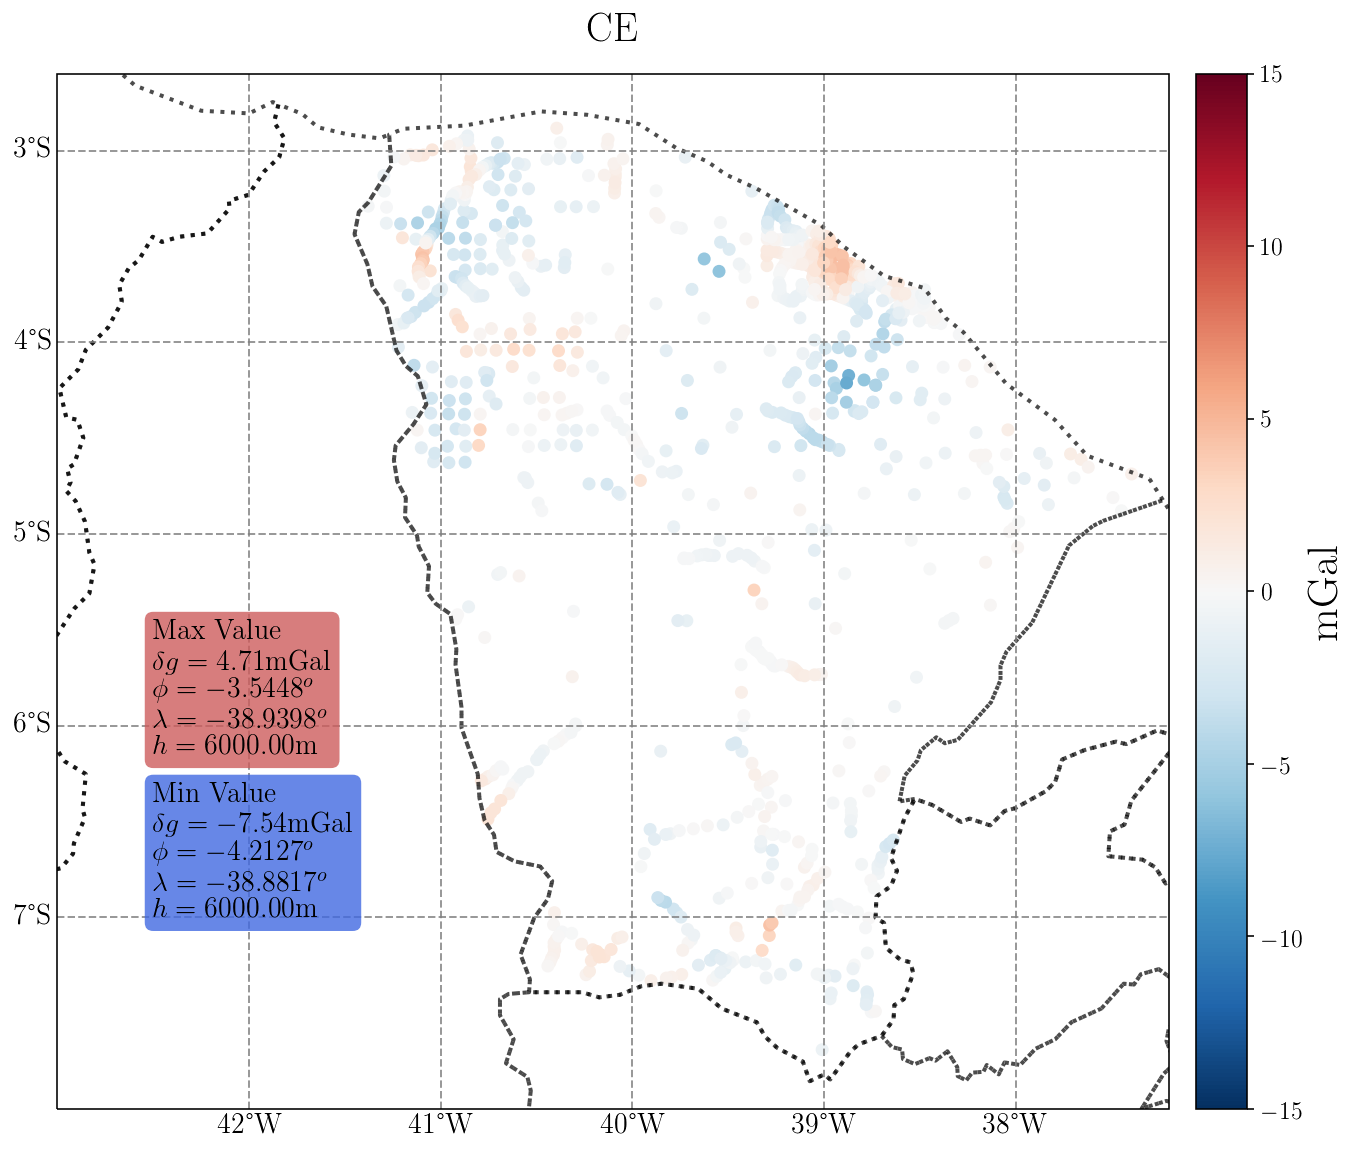

In [41]:
point_map(longitude, latitude, np.zeros_like(df.LONG)+6000., up_cont, uf, fig_size=(12.,14.), \
          region=[-43,-37.2,-8,-2.6], sign=(-42.5,-42.5,-6.15,-7), shrink=0.68, lim_val=(True, 15.))

In [42]:
# Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(longitude, latitude, 9000.,-3000.,p_L2)

The transformation is an upward continuation


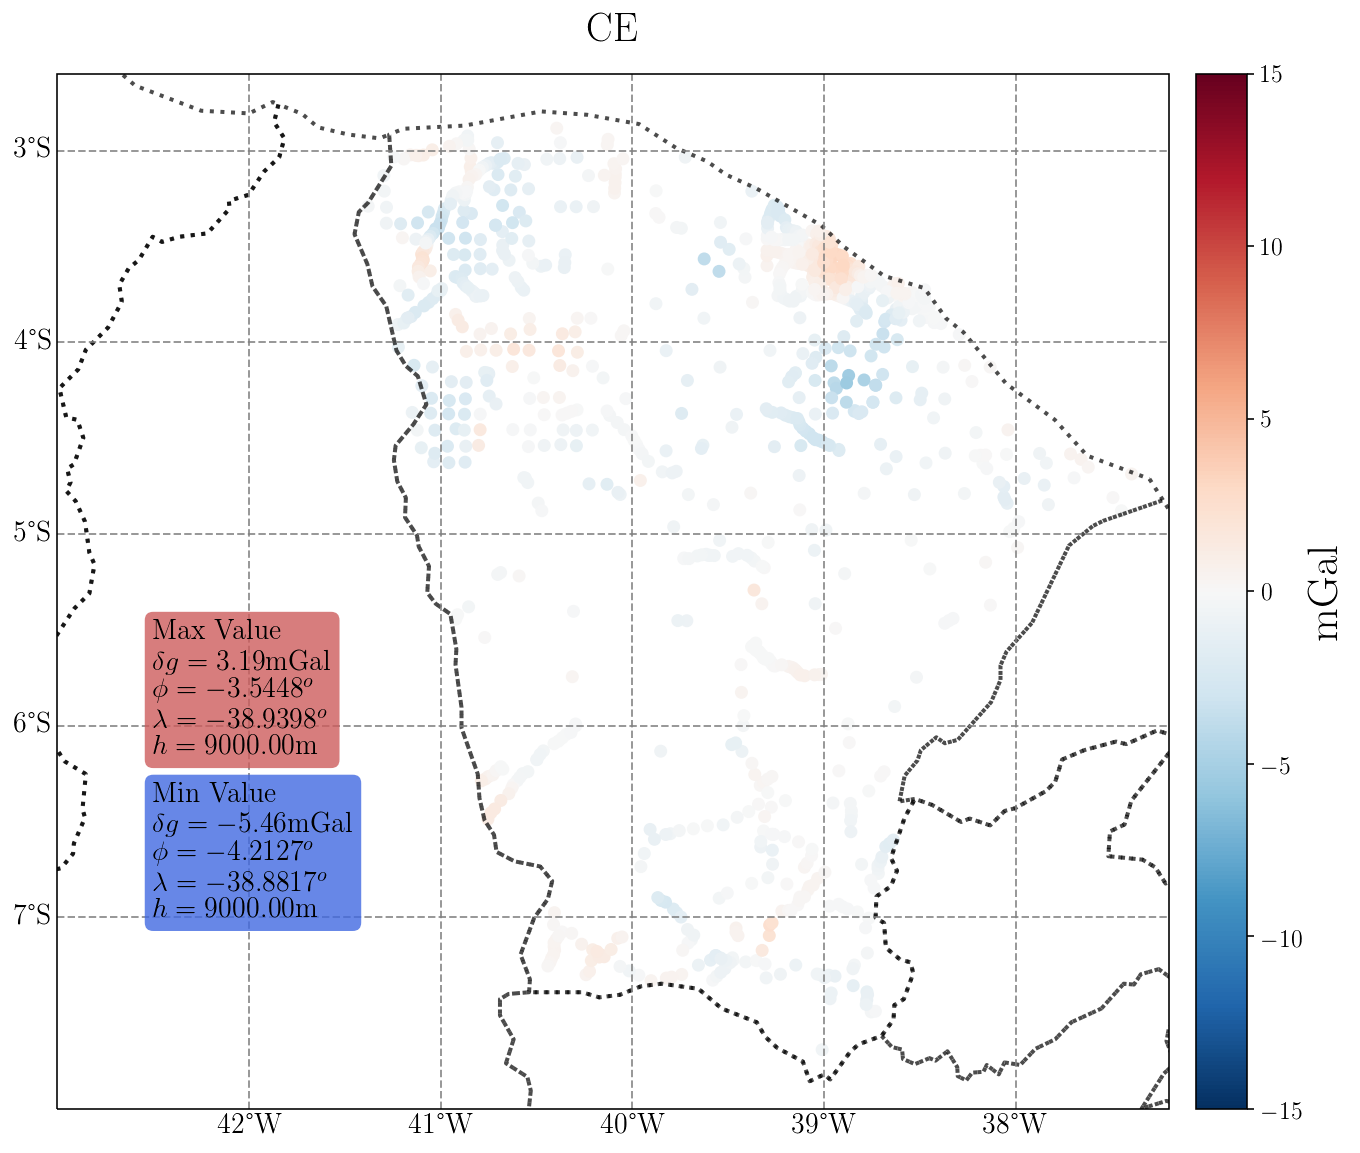

In [43]:
point_map(longitude, latitude, np.zeros_like(df.LONG)+9000., up_cont, uf, fig_size=(12.,14.), \
          region=[-43,-37.2,-8,-2.6], sign=(-42.5,-42.5,-6.15,-7), shrink=0.68, lim_val=(True, 15.))